## Major imports that are required along with preprocessing functions

In [12]:
import os
import json
import string
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

# deEmojify function
import re

p = re.compile(r'\\x..')

def deEmojify(inputString):
    return re.sub(p, "", inputString)
# ----------------------------------



# Preproccing and cleaning functions

# @ handles replacements
handle_regex = re.compile(r'(@[a-z0-9-_]+)')

# URLs replacer
url_regex = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

# String level replacements
rep = {
       "7-11"     : "seveneleven", 
       "7-eleven" : "seveneleven",
       "@7-eleven": "seveneleven",
       "@7-11"    : "seveneleven",
       "7 11"     : "seveneleven",
       "7/11"     : "seveneleven",
       "7 eleven" : "seveneleven",
       "&" : "and"
      } # define desired replacements here
rep = dict((re.escape(k), v) for k, v in rep.items())

# Token level replacement
regex_str = [
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\_]+[a-z])", # words with - and '
]

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)


def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token.lower() for token in tokens]
    return tokens

def clean_text(text):
    # First step is to lower all the text
    text = text.lower()
    
    # use these lines to do the replacement
    pattern = re.compile("|".join(rep.keys()))
    text = pattern.sub(lambda m: rep[re.escape(m.group(0))], text)
    
    # Remove all handles
    text = handle_regex.sub('', text)
    
    # Remove all URLs
    text = url_regex.sub('',text)
    
    cleaned_text = [word.strip() for word in tokens_re.findall(text)]
    cleaned_text = ' '.join(i for i in cleaned_text if i.isalpha())
    return cleaned_text
# Cleaning function ends ----------------------------------------------------

%matplotlib inline

## Wordcloud function setup

In [134]:
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

stopwords = set(STOPWORDS)
more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown', '.', '!',',','`','?','seveneleven','mohamed','si',
                  'big', 'gulp','jarritos','mandarin','lol'}
stopwords = stopwords.union(more_stopwords)

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    contour_width=3,
                    contour_color='firebrick',
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

## Reading and executing file and finally choosing the best column

## Your read and set dataframe steps should go below

In [ ]:
print("Before preprocessing")
print(df_sm_unique.shape)
df_sm_unique['Content'] = df_sm_unique['Content'].apply(lambda x: deEmojify(x))
print("Emojis Removed")
print(df_sm_unique.shape)
df_sm_unique = df_sm_unique[df_sm_unique['Content'] != '']
print("Empties Removed")
print(df_sm_unique.shape)
df_sm_unique['Content'] = df_sm_unique['Content'].apply(lambda x: x.lower())
print("All strings lowered")
df_sm_unique['cleaned'] = df_sm_unique['Content'].apply(lambda x: clean_text(x))
print("complete preprocessing")
print(df_sm_unique.shape)
df_sm_unique = df_sm_unique[df_sm_unique['cleaned'] != '']
print("Empties Removed")
print(df_sm_unique.shape)

In [ ]:
plot_wordcloud(df_sm_unique["cleaned"], title="")

In [ ]:
wordcloud.to_file("img/first_review.png")

In [ ]:
from collections import defaultdict

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in stopwords]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in df_sm_unique["cleaned"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])

fd_sorted.columns = ["word", "wordcount"]
#trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')
#trace0.

## Creating two subplots
#fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
#                          subplot_titles=["Frequent words of bad experience", 
#                                          "Frequent words of good experience"])
#fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
#fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
#py.iplot(fig, filename='word-plots')

plt.figure(figsize=(10,16))
sns.barplot(x="wordcount", y="word", data=fd_sorted.loc[3:23,:], color="b")
plt.title("Frequent words for big gulp", fontsize=16)
plt.show()

## Code ends unless you need sentiment stop here

In [3]:
#file_path = r'C:\Users\giridhar.c\Documents\Python Notebooks\PoC\big_gulp.xlsx'
#file_path = r'C:\Users\giridhar.c\Documents\Python Notebooks\PoC\jarritos.xlsx'
file_path = r'order_reviews.csv'

In [9]:
df = pd.read_csv(file_path, encoding = 'iso-8859-1')

In [10]:
df.head()

,Date,Name,Ratings,Review,Type
0,2019-10-25,1785773300073150074,3.0,Pizza a little cold,order review
1,2019-10-25,1785773300080282191,5.0,Great promotion. Tasty pizza. Service was ti...,order review
2,2019-10-25,1785773300069653941,5.0,Dope,order review
3,2019-10-25,1758773300097686936,5.0,Thanks for the free gift,order review
4,2019-10-25,1758773300275471440,5.0,Great,order review


In [102]:
df['Media Type'].unique()

array(['Twitter', 'Blog', 'TV, radio', 'Social network',
       'Video and Photo Sharing', 'Forum', 'Comments',
       'Consumer opinions'], dtype=object)

In [104]:
df[df['Media Type'].isin(['Twitter','Social network','Video and Photo Sharing'])]['Site Name'].unique()

array(['Twitter', 'Facebook', 'Dailymotion', 'YouTube', 'Instagram'],
      dtype=object)

In [105]:
df_sm = df[df['Media Type'].isin(['Twitter','Social network','Video and Photo Sharing'])]

In [106]:
df_sm.shape

(1735, 51)

In [107]:
df_sm.columns

Index(['Id', 'Date', 'Time', 'Media Type', 'Site Name', 'Site Domain',
       'Mention URL', 'Publisher Name', 'Publisher Username', 'Mention Title',
       'Mention Content', 'Topics', 'Subtopics', 'Sentiment', 'Star Rating',
       'Country', 'State', 'City', 'Language', 'Potential Reach',
       'Engagement Rate', 'Interactions Total', 'Earned Media Value',
       'Facebook Views', 'Facebook Likes', 'Facebook Comments',
       'Facebook Shares', 'Facebook love reactions', 'Facebook haha reactions',
       'Facebook wow reactions', 'Facebook sad reactions',
       'Facebook angry reactions', 'Twitter Retweets', 'Twitter Favorites',
       'Twitter replies', 'Instagram Views', 'Instagram Likes',
       'Instagram Comments', 'Youtube Views', 'Youtube Likes',
       'Youtube Dislikes', 'Youtube Comments', 'Youtube Favorites',
       'Synthesio Rank', 'User Age', 'User Gender', 'User Family Status',
       'User Marital Status', 'User Affinities', 'User Jobs',
       'User biography tags

In [110]:
df_sm_unique = df_sm[df_sm['Mention Content'] != 'Deleted or protected mention']['Mention Content'].drop_duplicates()

In [112]:
df_sm_unique = df_sm_unique.reset_index()

In [113]:
df_sm_unique['Mention Content'] = df_sm_unique['Mention Content'].apply(lambda x: deEmojify(x))

In [114]:
df_sm_unique = df_sm_unique[df_sm_unique['Mention Content'] != '']

In [115]:
df_sm_unique['Mention Content'] = df_sm_unique['Mention Content'].apply(lambda x: x.lower())

In [116]:
df_sm_unique.shape
# (1422, 2)

(1471, 2)

In [119]:
#df_bad_exp['cleaned'] = df_bad_exp['CUSTOMER_FEEDBACK_COMMENT'].apply(lambda x: clean_text(x))
#df_good_exp['cleaned'] = df_good_exp['CUSTOMER_FEEDBACK_COMMENT'].apply(lambda x: clean_text(x))
#df_nut_exp['cleaned'] = df_nut_exp['CUSTOMER_FEEDBACK_COMMENT'].apply(lambda x: clean_text(x))
df_sm_unique['cleaned'] = df_sm_unique['Mention Content'].apply(lambda x: clean_text(x))

In [120]:
df_sm_unique.head()

,index,Mention Content,cleaned
0,0,@ehhhokayy why mcdonald’s @nobrainrr get one o...,why mcdonald get one the seveneleven gulp straws
1,1,@qnntexas @truthserum4all https://twitter.com/...,the wuhan market which has since been closed a...
2,4,all you need is the 7-11 big gulp ... can't wa...,all you need the seveneleven big gulp wait see...
3,5,"""here's some fish & a brandy,"" she said, handi...",some fish and brandy she said handing him styr...
4,10,“[they have] the leadership ability of a 7-ele...,they have the leadership ability seveneleven b...


In [124]:
wine_mask.shape

(720, 1280, 3)

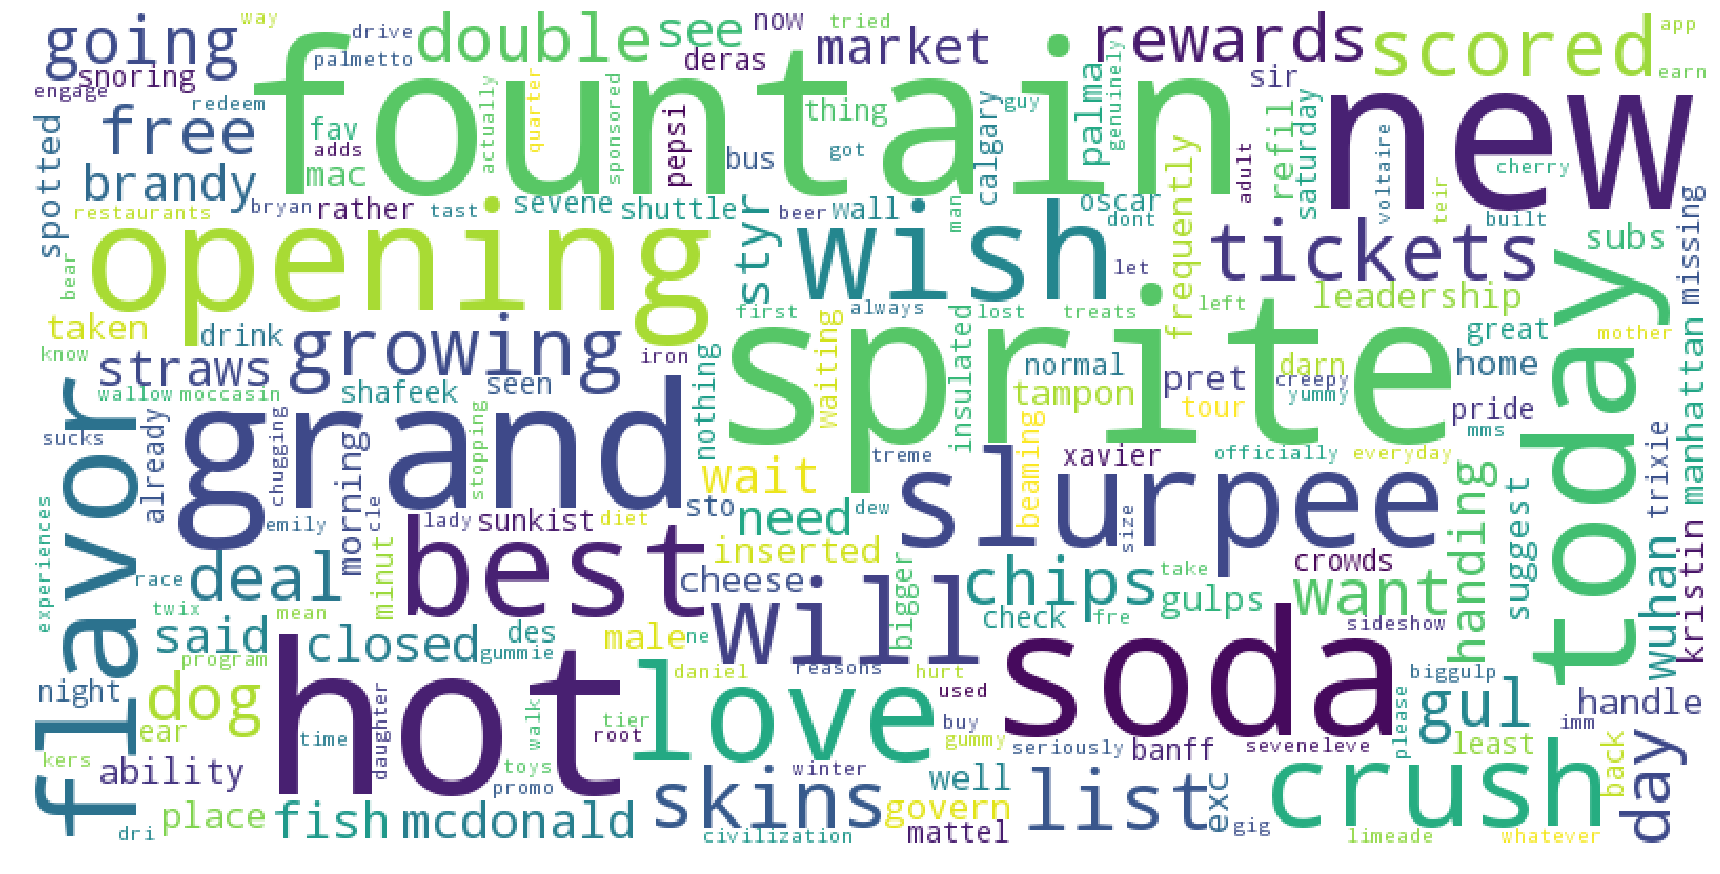

In [135]:
#plot_wordcloud(df_bad_exp["cleaned"], title="Word cloud of bad experience")
#plot_wordcloud(df_nut_exp["cleaned"], title="Word cloud of nut experience")
#plot_wordcloud(df_good_exp["cleaned"], title="Word cloud of good experience")
#wine_mask = np.array(Image.open("maxresdefault.jpg"))
#wine_mask = wine_mask.reshape((wine_mask.shape[0],-1), order='F')
#transformed_wine_mask = np.ndarray((wine_mask.shape[0],wine_mask.shape[1]), np.int32)

#for i in range(len(wine_mask)):
#    for j in range(len)
#    if wine_mask[i] == 0:
#        transformed_wine_mask[i] = 255
#    else:
#        transformed_wine_mask[i] = wine_mask[i]

plot_wordcloud(df_sm_unique["cleaned"], title="")#, mask = transformed_wine_mask)

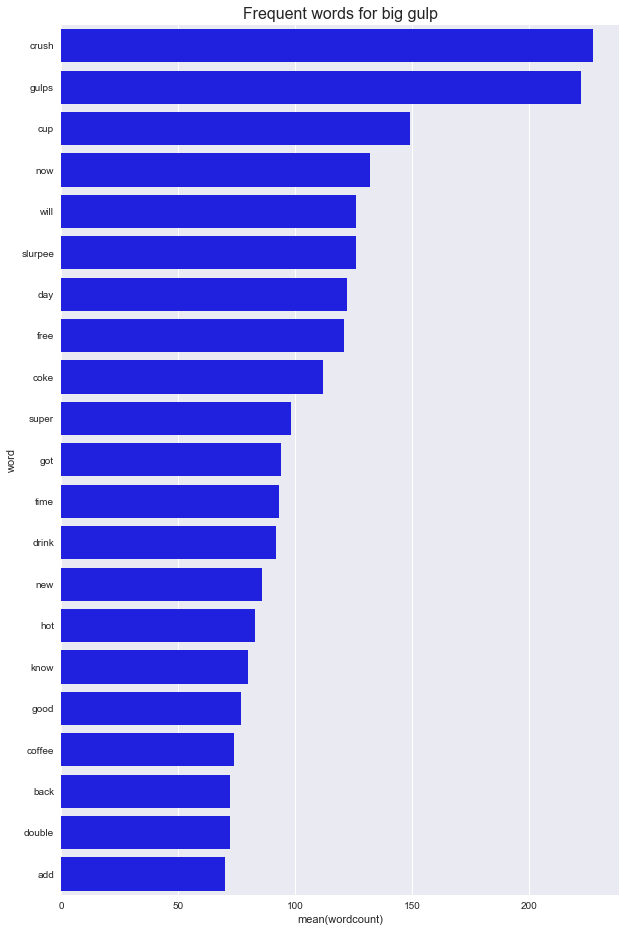

In [49]:
from collections import defaultdict

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in stopwords]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in df_sm_unique["cleaned"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])

fd_sorted.columns = ["word", "wordcount"]
#trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')
#trace0.

## Creating two subplots
#fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
#                          subplot_titles=["Frequent words of bad experience", 
#                                          "Frequent words of good experience"])
#fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
#fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
#py.iplot(fig, filename='word-plots')

plt.figure(figsize=(10,16))
sns.barplot(x="wordcount", y="word", data=fd_sorted.loc[3:23,:], color="b")
plt.title("Frequent words for big gulp", fontsize=16)
plt.show()

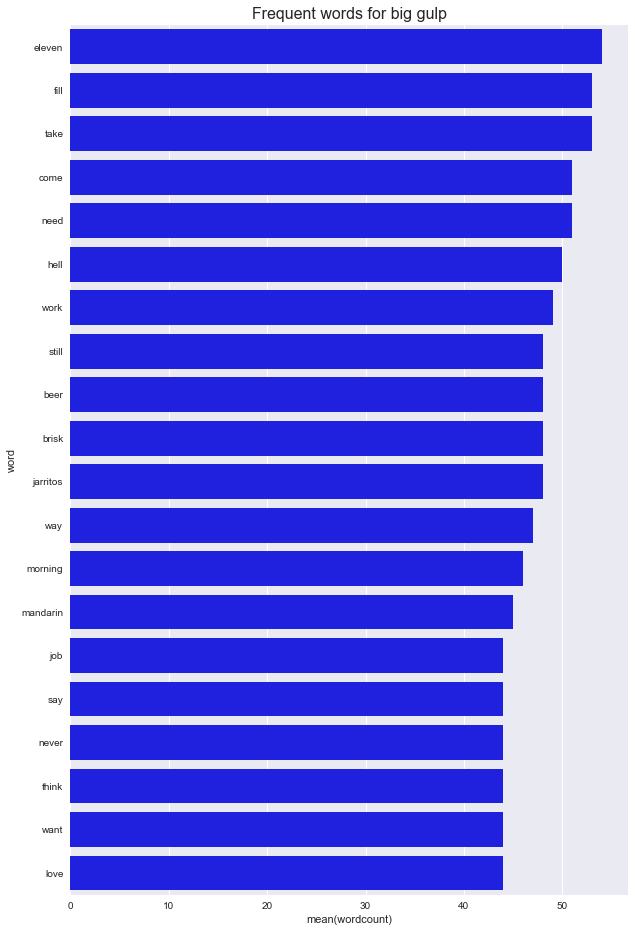

In [148]:
plt.figure(figsize=(10,16))
sns.barplot(x="wordcount", y="word", data=fd_sorted.loc[41:60,:], color="b")
plt.title("Frequent words for big gulp", fontsize=16)
plt.show()

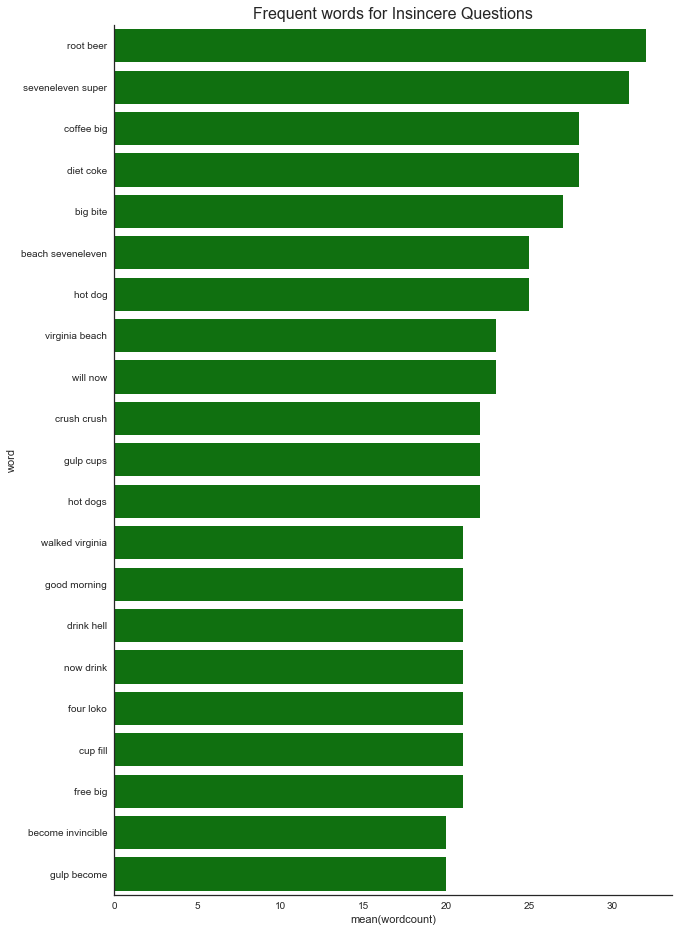

In [58]:
## custom function for ngram generation ##
def generate_ngrams(text, n_gram=2):
    token = [token for token in text.lower().split(" ") if token != "" if token not in stopwords]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in df_sm_unique["cleaned"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'red')

plt.figure(figsize=(10,16))
sns.set_style('white')
sns.barplot(x="wordcount", y="word", data=fd_sorted.loc[9:29,:], color="g")
sns.despine()
plt.title("Frequent words Associated with Big Gulp", fontsize=16)
plt.show()

In [92]:
from textblob import TextBlob

text = '''
Pizza was gross.
'''

#Forgot item in order but delivery was fast.

# 0.060
# -0.341


def get_sentence_lvl_sentiment(text):
    temp = []
    score = 0
    blob = TextBlob(text)
    for sentence in blob.sentences:
        temp.append(sentence.sentiment.polarity)
    for val in temp:
        if val < 0.0:
            score = -1
            break
        elif val == 0.0:
            score += 0
        elif val > 0.0:
            score += 1
    return score

In [ ]:
# import SentimentIntensityAnalyzer class 
# from vaderSentiment.vaderSentiment module. 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
  
# function to print sentiments 
# of the sentence. 
def sentiment_scores(sentence): 
  
    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer() 
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
      
    print("Overall sentiment dictionary is : ", sentiment_dict) 
    print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative") 
    print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral") 
    print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive") 
  
    print("Sentence Overall Rated As", end = " ") 
  
    # decide sentiment as positive, negative and neutral 
    if sentiment_dict['compound'] >= 0.05 : 
        print("Positive") 
  
    elif sentiment_dict['compound'] <= - 0.05 : 
        print("Negative") 
  
    else : 
        print("Neutral") 
  
  
    
# Driver code 
if __name__ == "__main__" : 
  
    print("\n1st statement :") 
    sentence = "The delivery took forever so my pizza was extremely cold." 
  
    # function calling 
    sentiment_scores(sentence) 
  
    print("\n2nd Statement :") 
    sentence = "Still has not arrived. It’s over 30 minutes late"
    sentiment_scores(sentence) 
  
    print("\n3rd Statement :") 
    sentence = "I am vey sad today."
    sentiment_scores(sentence) 